In [1]:
from __future__ import print_function, division
import pandas
import matplotlib.pyplot as plt
import h5py
import numpy as np

In [64]:
# ruta del archivo. tienen que cambiarla
filename = '/home/luciano/Physics/LHCOlympics2020/events_anomalydetection.h5'

In [3]:
# lee 11000 lineas solamente
datafile_test = pandas.read_hdf(filename,stop=11000)
# entrega la 'forma' del archivo de datos (filas, columnas)
print(datafile_test.shape)

(11000, 2101)


In [4]:
# esto da una idea de cuanta memoria se necesitaria para cargar en memoria el archivo *completo*
print("Memory used by this (in GB)",sum(datafile_test.memory_usage(deep=True))/(1024**3))

Memory used by this (in GB) 0.172272324562


In [5]:
# esto creo que loopea por sobre todo el archivo
# habia leido que era un 'yield' en python, pero ya se me olvido, era como importante
def generator(filename, chunksize=32,total_size=1100000):
    i = 0
    print("working")
    while True:
        yield pandas.read_hdf(filename, start=i*chunksize, stop=(i+1)*chunksize)
        i+=1
        if (i+1)*chunksize > total_size:
            i = 0

In [6]:
gen = generator(filename)

In [7]:
#############################
#############################
# ahora el ejemplo de pyjet
# OJO: pyjet no funciona con Python 3.7
# 3.6 funciona bien
from pyjet import cluster,DTYPE_PTEPM

In [8]:
# transpuesta (?)
events_combined = datafile_test.T
np.shape(events_combined)

(2101, 11000)

In [9]:
# esto tambien funciona, pandas tiene su propia funcion 'shape'
events_combined.shape

(2101, 11000)

In [48]:
# CLUSTERING
# esta parte reconstruye los jets a partir de las particulas individuales
leadPt = {}
alljets= {}

# MUY INEFICIENTE
# pero se corre una vez no mas
for mytype in ['background','signal']:
    leadPt[mytype]=[]
    alljets[mytype]=[]
    # leamos 1100 eventos (10%)
    for i in range(1100):
        # para revisar de vez en cuando que esta haciendo
        if (i%100==0):
            print(mytype,i)
            pass
        # la ultima columna del archivo te dice si es senal (1) or bkg (0)
        issignal = events_combined[i][2100]
        # esto seguro que se puede hacer mas eficientemente, esta recorriendo todo el archivo dos veces (?)
        if ( mytype == 'background' and issignal ):
            continue
        elif ( mytype == 'signal' and issignal==0 ):
            continue
        
        # arreglo 2dim lleno de ceros, despues llena con las particulas
        pseudojets_input = np.zeros(len([x for x in events_combined[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
        for j in range(700):
            # if equals zero, there's no more particles! stop reading!
            if ( events_combined[i][j*3] > 0) :
                pseudojets_input[j]['pT'] = events_combined[i][j*3]
                pseudojets_input[j]['eta'] = events_combined[i][j*3+1]
                pseudojets_input[j]['phi'] = events_combined[i][j*3+2]
            else :
                break
        # este es el clustering en si!
        # habria que leer la documentacion de 'pyjet'
        sequence = cluster(pseudojets_input, R=1.0, p=-1)
        # corte de pt (?)
        jets = sequence.inclusive_jets(ptmin=20)
        # la funcion de clustering seguramente ordena los jets
        # miembro pt, tambien debe haber eta y phi seguramennte
        leadPt[mytype]  += [jets[0].pt]
        alljets[mytype] += [jets]
        pass

background 0
background 100
background 200
background 300
background 400
background 500
background 600
background 700
background 800
background 900
background 1000
signal 0
signal 100
signal 200
signal 300
signal 400
signal 500
signal 600
signal 700
signal 800
signal 900
signal 1000


In [49]:
# revisemos algunos valores
len(leadPt),len(alljets),len(leadPt['signal']),len(leadPt['background']),len(alljets['signal']),len(alljets['background'])

(2, 2, 103, 997, 103, 997)

In [56]:
# output (2, 2, 93, 907, 93, 907)
# dos arreglos, uno para los leadPt (solo guarda el jet con mayor pT) y otro para alljets (guarda todo el jet)
# ambos tienen subarreglos "signal" y "background"
# signal tiene 103 eventos
# background 997 eventos

# cuantos pseudojets tienen los primeros 3 jets de senal?
print(len(alljets['signal'][0]), len(alljets['signal'][1]), len(alljets['signal'][2]))

4 2 2


In [53]:
# los leading pT de 3 eventos de senal:
print(leadPt['signal'][0], leadPt['signal'][1], leadPt['signal'][2])


1210.41578692 1787.62557329 1368.77625534


In [57]:
# ok ahora muestrame todos los jets de senal que tengan mas de 4 pseudojets, y cuantos tienen en total
for i in range(len(alljets['signal'])):
    if (len(alljets['signal'][i]) > 4):
        print(i,len(alljets['signal'][i]))

26 5
45 6
64 5
69 6
75 7
90 5
92 5


In [58]:
# y ahora dime para el evento 26 de senal, cuales son las caracteristicas de los 5 pseudojets
print(alljets['signal'][26])

[PseudoJet(pt=1740.437, eta=0.847, phi=1.077, mass=113.388), PseudoJet(pt=1717.329, eta=0.351, phi=-2.043, mass=591.818), PseudoJet(pt=47.271, eta=-0.581, phi=-1.504, mass=9.843), PseudoJet(pt=32.793, eta=1.627, phi=-1.862, mass=8.479), PseudoJet(pt=20.808, eta=-2.720, phi=-2.543, mass=9.917)]


In [59]:
# muestrame el primero solamente
print(alljets['signal'][26][0])

PseudoJet(pt=1740.437, eta=0.847, phi=1.077, mass=113.388)


In [44]:
# claro, este es el jet con leading pt. 1740.437 deberia ser lo mismo en el otro arreglo
print(leadPt['signal'][26])

1740.43749182


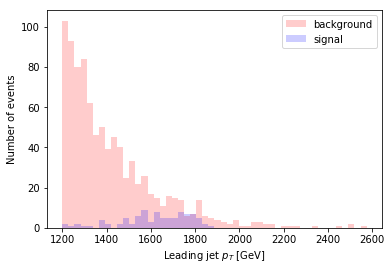

<Figure size 432x288 with 0 Axes>

In [45]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(leadPt['background'], bins=50, facecolor='r', alpha=0.2,label='background')
plt.hist(leadPt['signal'], bins=b, facecolor='b', alpha=0.2,label='signal')
plt.xlabel(r'Leading jet $p_{T}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.show()
plt.savefig("leadjetpt.pdf")
# con mas eventos se veria mas boni

In [60]:
# esto es como para meterse mas al archivo en si
# hice esto hace tiempo (el 18 de octubre para ser mas preciso) asi que no me acuerdo
datafile_h5py = h5py.File(filename,'r')

In [61]:
list(datafile_h5py.keys())

[u'df']

In [62]:
list(datafile_h5py['df'].keys())

[u'axis0', u'axis1', u'block0_items', u'block0_values']

In [63]:
for i in list(datafile_h5py['df'].keys()):
    print(datafile_h5py['df'][i].shape)
    

(2101,)
(1100000,)
(2101,)
(1100000, 2101)
